# Uproot and Awkward Arrays

## Tutorial for Electron Ion Collider users

Jim Pivarski (Princeton University)

In [1]:
import os
os.chdir("..")

## Table of contents

* [Uproot: getting data](#uproot)
    - [Exploring a TFile](#Exploring-a-TFile)
    - [Exploring a TTree](#Exploring-a-TTree)
    - [Turning ROOT branches into NumPy arrays](#Turning-ROOT-branches-into-NumPy-arrays)
    - [Memory management; caching and iteration](#Memory-management;-caching-and-iteration)
    - [Jagged arrays (segue)](#Jagged-arrays-(segue))
* [Awkward Array: manipulating data](#awkward)
    - [Using Uproot data in Awkward 1.0](#Using-Uproot-data-in-Awkward-1.0)
    - [Iteration in Python vs array-at-a-time operations](#Iteration-in-Python-vs-array-at-a-time-operations)
    - [Zipping arrays into records and projecting them back out](#Zipping-arrays-into-records-and-projecting-them-back-out)
    - [Filtering (cutting) events and particles with advanced selections](#Filtering-(cutting)-events-and-particles-with-advanced-selections)
    - [Flattening for plots and regularizing to NumPy for machine learning](#Flattening-for-plots-and-regularizing-to-NumPy-for-machine-learning)
    - [Broadcasting flat arrays and jagged arrays](#Broadcasting-flat-arrays-and-jagged-arrays)
    - [Combinatorics: cartesian and combinations](#Combinatorics:-cartesian-and-combinations)
    - [Reducing from combinations](#Reducing-from-combinations)
    - [Imperative, but still fast, programming in Numba](#Imperative,-but-still-fast,-programming-in-Numba)
    - [Grafting jagged data onto Pandas](#Grafting-jagged-data-onto-Pandas)
    - [NumExpr, Autograd, and other third-party libraries](#NumExpr,-Autograd,-and-other-third-party-libraries)

<br>
<br>
<a name="uproot"></a>
<img src="https://github.com/scikit-hep/uproot/raw/master/docs/source/logo-600px.png" width="300">

Uproot is a pure Python reimplementation of a significant part of ROOT I/O.

<br>
<img src="https://raw.githubusercontent.com/jpivarski/2019-07-29-dpf-python/master/img/abstraction-layers.png" width="700">
<br>

You can read TTrees containing basic data types, STL vectors, strings, and some more complex data, especially if it was written with a high "splitLevel".

You can also read histograms and other objects into generic containers, but the C++ methods that give those objects functionality are not available.

## Exploring a TFile

Uproot was designed to be Pythonic, so the way we interact with ROOT files is different than it is in ROOT.

In [2]:
import uproot
file = uproot.open("docs-demo-notebooks/open_charm_18x275_10k.root")

A ROOT file may be thought of as a dict of key-value pairs, like a Python dict.

In [3]:
file.keys()

[b'events;1']

In [4]:
file.values()

[<ROOTDirectory b'events' at 0x7f912409bd50>]

**What's the `b` before the name?** All strings retrieved from ROOT are unencoded, which Python 3 treats differently from Python 2. In the near future, Uproot will automatically interpret all strings from ROOT as UTF-8 and this cosmetic issue will be gone.

**What's the `;1` at the end of the name?** It's the cycle number, something ROOT uses to track multiple versions of an object. You can usually ignore it.

Nested directories are a dict of dicts.

In [5]:
file["events"].keys()

[b'tree;2', b'tree;1']

In [6]:
file["events"]["tree"]

<TTree b'tree' at 0x7f91240b0610>

But there are shortcuts:

   * use a `/` to navigate through the levels in a single string;
   * use `allkeys` to recursively show all keys in all directories.

In [7]:
file.allkeys()

[b'events;1', b'events/tree;2', b'events/tree;1']

In [8]:
file["events/tree"]

<TTree b'tree' at 0x7f91241de890>

## Exploring a TTree

A TTree can also be thought of as a dict of dicts, this time to navigate through TBranches.

In [3]:
tree = file["events/tree"]
tree.keys()

[b'evt_id',
 b'evt_true_q2',
 b'evt_true_x',
 b'evt_true_y',
 b'evt_true_w2',
 b'evt_true_nu',
 b'evt_has_dis_info',
 b'evt_prt_count',
 b'evt_weight',
 b'id',
 b'pdg',
 b'trk_id',
 b'charge',
 b'dir_x',
 b'dir_y',
 b'dir_z',
 b'p',
 b'px',
 b'py',
 b'pz',
 b'tot_e',
 b'm',
 b'time',
 b'is_beam',
 b'is_stable',
 b'gen_code',
 b'mother_id',
 b'mother_second_id',
 b'has_pol_info',
 b'pol_x',
 b'pol_y',
 b'pol_z',
 b'has_vtx_info',
 b'vtx_id',
 b'vtx_x',
 b'vtx_y',
 b'vtx_z',
 b'vtx_t',
 b'has_smear_info',
 b'smear_has_e',
 b'smear_has_p',
 b'smear_has_pid',
 b'smear_has_vtx',
 b'smear_has_any_eppid',
 b'smear_orig_tot_e',
 b'smear_orig_p',
 b'smear_orig_px',
 b'smear_orig_py',
 b'smear_orig_pz',
 b'smear_orig_vtx_x',
 b'smear_orig_vtx_y',
 b'smear_orig_vtx_z']

Often, the first thing I do when I look at a TTree is `show` to see how each branch is going to be interpreted.

In [10]:
print("branch name              streamer (for complex data)  interpretation in Python")
print("==============================================================================")

tree.show()

branch name              streamer (for complex data)  interpretation in Python
evt_id                     (no streamer)              asdtype('>u8')
evt_true_q2                (no streamer)              asdtype('>f8')
evt_true_x                 (no streamer)              asdtype('>f8')
evt_true_y                 (no streamer)              asdtype('>f8')
evt_true_w2                (no streamer)              asdtype('>f8')
evt_true_nu                (no streamer)              asdtype('>f8')
evt_has_dis_info           (no streamer)              asdtype('int8')
evt_prt_count              (no streamer)              asdtype('>u8')
evt_weight                 (no streamer)              asdtype('>f8')
id                         (no streamer)              asjagged(asdtype('>u8'))
pdg                        (no streamer)              asjagged(asdtype('>i8'))
trk_id                     (no streamer)              asjagged(asdtype('>f8'))
charge                     (no streamer)              asjagged

Most of the information you'd expect to find in a TTree is there. See [uproot.readthedocs.io](https://uproot.readthedocs.io/en/latest/ttree-handling.html) for a complete list.

In [11]:
tree.numentries

10000

In [12]:
tree["evt_id"].compressedbytes(), tree["evt_id"].uncompressedbytes(), tree["evt_id"].compressionratio()

(15417, 80000, 5.189076992929882)

In [13]:
tree["evt_id"].numbaskets

3

In [14]:
[tree["evt_id"].basket_entrystart(i) for i in range(3)]

[0, 3990, 5883]

## Turning ROOT branches into NumPy arrays

There are several methods for this; they differ only in convenience.

In [15]:
# TBranch → array
tree["evt_id"].array()

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64)

In [16]:
# TTree + branch name → array
tree.array("evt_id")

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64)

In [17]:
# TTree + branch names → arrays
tree.arrays(["evt_id", "evt_prt_count"])

{b'evt_id': array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64),
 b'evt_prt_count': array([51, 26, 27, ..., 42, 25, 11], dtype=uint64)}

In [18]:
# TTree + branch name pattern(s) → arrays
tree.arrays("evt_*")

{b'evt_id': array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64),
 b'evt_true_q2': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_x': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_y': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_w2': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_nu': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_has_dis_info': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 b'evt_prt_count': array([51, 26, 27, ..., 42, 25, 11], dtype=uint64),
 b'evt_weight': array([0., 0., 0., ..., 0., 0., 0.])}

In [19]:
# TTree + branch name regex(s) → arrays
tree.arrays("/evt_[A-Z_0-9]*/i")

{b'evt_id': array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64),
 b'evt_true_q2': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_x': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_y': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_w2': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_true_nu': array([0., 0., 0., ..., 0., 0., 0.]),
 b'evt_has_dis_info': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 b'evt_prt_count': array([51, 26, 27, ..., 42, 25, 11], dtype=uint64),
 b'evt_weight': array([0., 0., 0., ..., 0., 0., 0.])}

**Convenience #1:** turn the bytestrings into real strings (will soon be unnecessary).

In [20]:
tree.arrays("evt_*", namedecode="utf-8")

{'evt_id': array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64),
 'evt_true_q2': array([0., 0., 0., ..., 0., 0., 0.]),
 'evt_true_x': array([0., 0., 0., ..., 0., 0., 0.]),
 'evt_true_y': array([0., 0., 0., ..., 0., 0., 0.]),
 'evt_true_w2': array([0., 0., 0., ..., 0., 0., 0.]),
 'evt_true_nu': array([0., 0., 0., ..., 0., 0., 0.]),
 'evt_has_dis_info': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 'evt_prt_count': array([51, 26, 27, ..., 42, 25, 11], dtype=uint64),
 'evt_weight': array([0., 0., 0., ..., 0., 0., 0.])}

**Convenience #2:** output a tuple instead of a dict.

In [21]:
tree.arrays(["evt_id", "evt_prt_count"], outputtype=tuple)

(array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64),
 array([51, 26, 27, ..., 42, 25, 11], dtype=uint64))

... to use it in assignment:

In [22]:
evt_id, evt_prt_count = tree.arrays(["evt_id", "evt_prt_count"], outputtype=tuple)

In [23]:
evt_id

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64)

## Memory management; caching and iteration

The `array` methods read an entire branch into memory. Sometimes, you might not have enough memory to do that.

The simplest solution is to set `entrystart` (inclusive) and `entrystop` (exclusive) to read a small batch at a time.

In [24]:
tree.array("evt_id", entrystart=500, entrystop=600)

array([500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512,
       513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525,
       526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538,
       539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551,
       552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564,
       565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577,
       578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590,
       591, 592, 593, 594, 595, 596, 597, 598, 599], dtype=uint64)

Uproot is _not_ agressive about caching: if you call `arrays` many times (for many small batches), it will read from the file every time.

You can avoid frequent re-reading by assigning arrays to variables, but then you'd have to manage all those variables.

**Instead, use explicit caching:**

In [25]:
# Make a cache with an acceptable limit.
gigabyte_cache = uproot.ArrayCache("1 GB")

# Read the array from disk:
tree.array("evt_id", cache=gigabyte_cache)

# Get the array from the cache:
tree.array("evt_id", cache=gigabyte_cache)

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint64)

The advantage is that the same code can be used for first time and subsequent times. You can put this in a loop.

Naturally, fetching from the cache is much faster than reading from disk (though our file isn't very big!).

In [26]:
%%timeit

tree.arrays("*")

564 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%%timeit

tree.arrays("*", cache=gigabyte_cache)

2.19 ms ± 37.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


The value of an explicit cache is that you get to control it.

In [28]:
len(gigabyte_cache)

52

In [29]:
gigabyte_cache.clear()

In [30]:
len(gigabyte_cache)

0

Setting `entrystart` and `entrystop` can get annoying; we probably want to do it in a loop.

There's a method, `iterate`, for that.

In [31]:
for arrays in tree.iterate("evt_*", entrysteps=1000):
    print({name: len(array) for name, array in arrays.items()})

{b'evt_id': 1000, b'evt_true_q2': 1000, b'evt_true_x': 1000, b'evt_true_y': 1000, b'evt_true_w2': 1000, b'evt_true_nu': 1000, b'evt_has_dis_info': 1000, b'evt_prt_count': 1000, b'evt_weight': 1000}
{b'evt_id': 1000, b'evt_true_q2': 1000, b'evt_true_x': 1000, b'evt_true_y': 1000, b'evt_true_w2': 1000, b'evt_true_nu': 1000, b'evt_has_dis_info': 1000, b'evt_prt_count': 1000, b'evt_weight': 1000}
{b'evt_id': 1000, b'evt_true_q2': 1000, b'evt_true_x': 1000, b'evt_true_y': 1000, b'evt_true_w2': 1000, b'evt_true_nu': 1000, b'evt_has_dis_info': 1000, b'evt_prt_count': 1000, b'evt_weight': 1000}
{b'evt_id': 1000, b'evt_true_q2': 1000, b'evt_true_x': 1000, b'evt_true_y': 1000, b'evt_true_w2': 1000, b'evt_true_nu': 1000, b'evt_has_dis_info': 1000, b'evt_prt_count': 1000, b'evt_weight': 1000}
{b'evt_id': 1000, b'evt_true_q2': 1000, b'evt_true_x': 1000, b'evt_true_y': 1000, b'evt_true_w2': 1000, b'evt_true_nu': 1000, b'evt_has_dis_info': 1000, b'evt_prt_count': 1000, b'evt_weight': 1000}
{b'evt_id'

Keep in mind that this is a loop over _batches_, not _events_.

What goes in the loop is code that applies to _arrays_.

You can also set the `entrysteps` to be a size in memory.

In [32]:
for arrays in tree.iterate("evt_*", entrysteps="100 kB"):
    print({name: len(array) for name, array in arrays.items()})

{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id'

The same size in memory covers more events if you read fewer branches.

In [33]:
for arrays in tree.iterate("evt_id", entrysteps="100 kB"):
    print({name: len(array) for name, array in arrays.items()})

{b'evt_id': 10000}


This `TTree.iterate` method is similar in form to the `uproot.iterate` function, which iterates in batches over a collection of files.

In [34]:
for arrays in uproot.iterate(["docs-demo-notebooks/open_charm_18x275_10k.root",
                              "docs-demo-notebooks/open_charm_18x275_10k.root",
                              "docs-demo-notebooks/open_charm_18x275_10k.root"], "events/tree", "evt_*", entrysteps="100 kB"):
    print({name: len(array) for name, array in arrays.items()})

{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id': 1576, b'evt_true_q2': 1576, b'evt_true_x': 1576, b'evt_true_y': 1576, b'evt_true_w2': 1576, b'evt_true_nu': 1576, b'evt_has_dis_info': 1576, b'evt_prt_count': 1576, b'evt_weight': 1576}
{b'evt_id'

## Jagged arrays (segue)

Most of the branches in this file have an "asjagged" interpretation, instead of "asdtype" (NumPy).

In [35]:
tree["evt_id"].interpretation

asdtype('>u8')

In [36]:
tree["pdg"].interpretation

asjagged(asdtype('>i8'))

This means that they have multiple values per entry.

In [37]:
tree["pdg"].array()

<JaggedArray [[11 211 -211 ... 22 22 22] [11 211 -211 ... -211 22 22] [11 2112 2212 ... 22 22 -211] ... [11 -211 321 ... 22 22 22] [11 2112 -211 ... 22 22 130] [11 -211 -321 ... 130 22 22]] at 0x7f9124065250>

Jagged arrays (lists of variable-length sublists) are very common in particle physics, and surprisingly uncommon in other fields.

We need them because we almost always have a variable number of particles per event.

In [4]:
from particle import Particle     # https://github.com/scikit-hep/particle

counter = 0
for event in tree["pdg"].array():
    print(len(event), "particles:", " ".join(Particle.from_pdgid(x).name for x in event))
    counter += 1
    if counter == 30:
        break

51 particles: e- pi+ pi- K- pi+ pi- pi- pi+ pi+ pi+ gamma gamma K(L)0 K+ pi- K(L)0 gamma gamma gamma gamma pi+ pi- pi+ gamma gamma p pi- pi+ K+ pi- pi- K+ K- gamma gamma pi+ pi- K+ pi- pi+ K(L)0 K(L)0 gamma gamma pi+ pi- pi+ gamma gamma gamma gamma
26 particles: e- pi+ pi- n~ n gamma pi- pi+ gamma gamma pi+ gamma gamma gamma gamma gamma K(L)0 gamma gamma gamma gamma pi- pi+ pi- gamma gamma
27 particles: e- n p pi+ pi+ pi+ pi- pi- pi- pi- pi- pi+ pi- gamma gamma gamma pi+ K+ K- pi+ gamma gamma gamma gamma gamma gamma pi-
28 particles: e- pi+ pi- nu(mu) mu+ gamma gamma pi- pi+ n gamma gamma n pi- p~ pi+ gamma gamma pi+ pi- K- K(L)0 gamma gamma gamma gamma gamma gamma
30 particles: e- pi+ pi- pi+ pi- n gamma gamma K- pi+ n pi- pi+ gamma n~ p~ pi+ K(L)0 gamma gamma pi- gamma gamma pi- pi+ gamma gamma K+ pi- gamma
12 particles: e- gamma gamma gamma gamma gamma gamma gamma gamma gamma gamma gamma
25 particles: pi- K- K+ pi- gamma gamma pi- gamma gamma pi- K(L)0 K(L)0 gamma gamma gamma gamma 

Although you can iterate over jagged arrays with for loops, the idiomatic and faster way to do it is with array-at-a-time functions.

In [5]:
import numpy as np

vtx_x, vtx_y, vtx_z = tree.arrays(["vtx_[xyz]"], outputtype=tuple)

vtx_dist = np.sqrt(vtx_x**2 + vtx_y**2 + vtx_z**2)

vtx_dist

<JaggedArray [[0.010869109735358505 0.04461569970007986 0.018400738439694277 ... 3.1836758411592023 3.183642553033989 3.183642553033989] [0.00044890687568113205 0.03373796683736145 0.05401859969095815 ... 131.99585878615915 0.028563725689861715 0.028563725689861715] [0.036756813467945904 4.486285131592035e-10 0.04416327313376598 ... 1.2533205300290502 1.2533205300290502 0.5367743154487575] ... [0.008254781290207314 0.01227106989388853 0.018030435962753534 ... 2.5798363404850953e-05 1.3027315899452183 1.3027315899452183] [0.0007829175274973732 4.5649022026043563e-10 0.00177464214391142 ... 0.00013687824404269707 0.00013687824404269707 8.543815169675133] [0.03541578165022657 0.002674912324039225 0.008526111534115434 ... 0.36799639096494413 0.3687648973563558 0.3687648973563558]] at 0x7f83444d2b50>

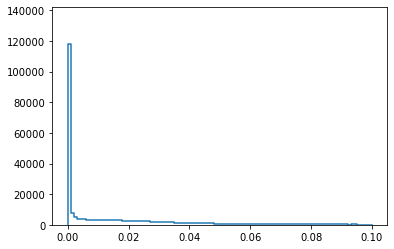

In [6]:
import matplotlib.pyplot as plt
import mplhep as hep             # https://github.com/scikit-hep/mplhep
import boost_histogram as bh     # https://github.com/scikit-hep/boost-histogram

vtx_hist = bh.Histogram(bh.axis.Regular(100, 0, 0.1))

vtx_hist.fill(vtx_dist.flatten())

hep.histplot(vtx_hist)

In [41]:
vtx_dist > 0.01

<JaggedArray [[True True True ... True True True] [False True True ... True True True] [True False True ... True True True] ... [False True True ... False True True] [False False False ... False False True] [True False False ... True True True]] at 0x7f91011d7b10>

In [42]:
pdg = tree["pdg"].array()
pdg[vtx_dist > 0.01]

<JaggedArray [[11 211 -211 ... 22 22 22] [211 -211 -211 ... -211 22 22] [11 2212 211 ... 22 22 -211] ... [-211 321 -321 ... -211 22 22] [211 -211 211 ... 211 -211 130] [11 2112 -211 ... 130 22 22]] at 0x7f912407b590>

In [43]:
counter = 0
for event in pdg[vtx_dist > 0.10]:
    print(len(event), "particles:", " ".join(Particle.from_pdgid(x).name for x in event))
    counter += 1
    if counter == 30:
        break

16 particles: p pi- K+ pi- pi- pi+ pi- pi+ K(L)0 pi+ pi- pi+ gamma gamma gamma gamma
9 particles: pi- pi+ K(L)0 gamma gamma gamma gamma pi+ pi-
8 particles: pi- pi- K+ K- pi+ gamma gamma pi-
7 particles: nu(mu) mu+ pi+ pi- K- gamma gamma
8 particles: K- pi+ p~ pi+ pi- pi+ K+ pi-
6 particles: gamma gamma gamma gamma gamma gamma
2 particles: K- K(L)0
1 particles: n
0 particles: 
12 particles: K- pi+ pi- K(L)0 pi- pi+ gamma gamma gamma gamma gamma gamma
7 particles: pi+ pi- K(L)0 pi+ K- gamma gamma
10 particles: pi+ pi- nu(e)~ e- K+ K(L)0 gamma gamma gamma gamma
11 particles: n pi+ K- gamma gamma gamma gamma p~ pi+ pi+ pi-
6 particles: K+ pi+ pi- pi- gamma gamma
16 particles: pi- pi- pi+ gamma gamma pi- K- pi+ pi+ pi- gamma gamma gamma gamma gamma gamma
6 particles: K+ pi- gamma gamma gamma gamma
10 particles: pi- pi+ p~ e+ e- gamma gamma gamma gamma gamma
18 particles: n pi- n~ pi+ n pi+ pi- pi+ pi- p pi- n~ pi+ pi+ gamma gamma gamma gamma
11 particles: nu(e) e+ K- K+ pi- pi+ pi- gamma g

In [44]:
Particle.from_string("p~")

<Particle: name="p~", pdgid=-2212, mass=938.272081 ± 0.000006 MeV>

In [45]:
Particle.from_string("p~").pdgid

<PDGID: -2212>

In [46]:
is_antiproton = (pdg == Particle.from_string("p~").pdgid)
is_antiproton

<JaggedArray [[False False False ... False False False] [False False False ... False False False] [False False False ... False False False] ... [False False False ... False False False] [False False False ... False False False] [False False False ... False False False]] at 0x7f910118af50>

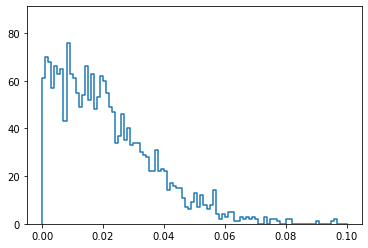

In [47]:
hep.histplot(bh.Histogram(bh.axis.Regular(100, 0, 0.1)).fill(
    vtx_dist[is_antiproton].flatten()
))

But that's a topic for the next section.

<br>
<br>
<a name="awkward"></a>
<img src="https://github.com/scikit-hep/awkward-1.0/raw/master/docs-images/logo/logo-600px.png" width="400">

Awkward Array is a library for manipulating arbitrary data structures in a NumPy-like way.

The idea is that you have a large number of identically typed, nested objects in variable-length lists.

<img src="../docs-images/diagrams/cartoon-schematic.png" width="600">

## Using Uproot data in Awkward 1.0

Awkward Array is in transition from

   * version 0.x, which is in use at the LHC but has revealed some design flaws, to
   * version 1.x, which is well-architected and has completed development, but is not in widespread use yet.

Awkward 1.0 hasn't been incorporated into Uproot yet, which is how it will get in front of most users.

Since development is complete and the interface is (intentionally) different, I thought it better to show you the new version.

In [7]:
import awkward1 as ak

Old-style arrays can be converted into the new framework with [ak.from_awkward0](https://awkward-array.readthedocs.io/en/latest/_auto/ak.from_awkward0.html). This won't be a necessary step for long.

In [49]:
?ak.from_awkward0

Signature:
ak.from_awkward0(
    array,
    keeplayout=False,
    regulararray=False,
    highlevel=True,
    behavior=None,
)
Docstring:
Args:
    array (Awkward 0.x or Awkward 1.x array): Data to convert to Awkward
        1.x.
    keeplayout (bool): If True, stay true to the Awkward 0.x layout,
        ensuring zero-copy; otherwise, allow transformations that copy
        data for more flexibility.
    regulararray (bool): If True and the array is multidimensional,
        the dimensions are represented by nested #ak.layout.RegularArray
        nodes; if False and the array is multidimensional, the dimensions
        are represented by a multivalued #ak.layout.NumpyArray.shape.
        If the array is one-dimensional, this has no effect.
    highlevel (bool): If True, return an #ak.Array; otherwise, return
        a low-level #ak.layout.Content subclass.
    behavior (bool): Custom #ak.behavior for the output array, if
        high-level.

Converts an array from Awkward 0.x to Awkwa

In [50]:
?ak.to_awkward0

Signature: ak.to_awkward0(array, keeplayout=False)
Docstring:
Args:
    array: Data to convert into an Awkward 0.x array.
    keeplayout (bool): If True, stay true to the Awkward 1.x layout,
        ensuring zero-copy; otherwise, allow transformations that copy
        data for more flexibility.

Converts `array` (many types supported, including all Awkward Arrays and
Records) into an Awkward 0.x array.

This is only needed during the transition from the old library to the new
library.
File:      ~/irishep/awkward-1.0/awkward1/operations/convert.py
Type:      function


In [51]:
ak.from_awkward0(tree.array("pdg"))

<Array [[11, 211, -211, -321, ... 130, 22, 22]] type='10000 * var * int64'>

In [8]:
arrays = {name: ak.from_awkward0(array) for name, array in tree.arrays(namedecode="utf-8").items()}
arrays

{'evt_id': <Array [0, 1, 2, 3, ... 9996, 9997, 9998, 9999] type='10000 * uint64'>,
 'evt_true_q2': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * float64'>,
 'evt_true_x': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * float64'>,
 'evt_true_y': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * float64'>,
 'evt_true_w2': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * float64'>,
 'evt_true_nu': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * float64'>,
 'evt_has_dis_info': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * int8'>,
 'evt_prt_count': <Array [51, 26, 27, 28, 30, ... 37, 42, 25, 11] type='10000 * uint64'>,
 'evt_weight': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * float64'>,
 'id': <Array [[12, 79, 80, 81, ... 54, 60, 61, 62]] type='10000 * var * uint64'>,
 'pdg': <Array [[11, 211, -211, -321, ... 130, 22, 22]] type='10000 * var * int64'>,
 'trk_id': <Array [[0, 0, 0, 0, 0, 0,

## Iteration in Python vs array-at-a-time operations

As before, you _can_ iterate over them in Python, but only do that for small-scale exploration.

In [53]:
%%timeit -n1 -r1

vtx_dist = []
for xs, xy, xz in zip(arrays["vtx_x"], arrays["vtx_y"], arrays["vtx_z"]):
    out = []
    for x, y, z in zip(xs, xy, xz):
        out.append(np.sqrt(x**2 + y**2 + z**2))
    vtx_dist.append(out)

10.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [54]:
%%timeit -n100 -r1

vtx_dist = np.sqrt(arrays["vtx_x"]**2 + arrays["vtx_y"]**2 + arrays["vtx_z"]**2)

24.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)


## Zipping arrays into records and projecting them back out

Instead of having all these arrays floating around, let's [ak.zip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.zip.html) them into a structure.

(This is the sort of thing that a framework developer might do for the data analysts.)

In [55]:
?ak.zip

Signature:
ak.zip(
    arrays,
    depthlimit=None,
    parameters=None,
    with_name=None,
    highlevel=True,
)
Docstring:
Args:
    arrays (dict or iterable of arrays): Arrays to combine into a
        record-containing structure (if a dict) or a tuple-containing
        structure (if any other kind of iterable).
    depthlimit (None or int): If None, attempt to fully broadcast the
        `array` to all levels. If an int, limit the number of dimensions
        that get broadcasted. The minimum value is `1`, for no
        broadcasting.
    parameters (dict): Parameters for the new #ak.layout.RecordArray node
        that is created by this operation.
    with_name (None or str): Assigns a `"__record__"` name to the new
        #ak.layout.RecordArray node that is created by this operation
        (overriding `parameters`, if necessary).
    highlevel (bool): If True, return an #ak.Array; otherwise, return
        a low-level #ak.layout.Content subclass.

Combines `arrays` into a si

In [9]:
events = ak.zip({"id": arrays["evt_id"],
                 "true": ak.zip({"q2": arrays["evt_true_q2"],
                                 "x": arrays["evt_true_x"],
                                 "y": arrays["evt_true_y"],
                                 "w2": arrays["evt_true_w2"],
                                 "nu": arrays["evt_true_nu"]}),
                 "has_dis_info": arrays["evt_has_dis_info"],
                 "prt_count": arrays["evt_prt_count"],
                 "prt": ak.zip({"id": arrays["id"],
                                "pdg": arrays["pdg"],
                                "trk_id": arrays["trk_id"],
                                "charge": arrays["charge"],
                                "dir": ak.zip({"x": arrays["dir_x"],
                                               "y": arrays["dir_y"],
                                               "z": arrays["dir_z"]}, with_name="point3"),
                                "p": arrays["p"],
                                "px": arrays["px"],
                                "py": arrays["py"],
                                "pz": arrays["pz"],
                                "m": arrays["m"],
                                "time": arrays["time"],
                                "is_beam": arrays["is_beam"],
                                "is_stable": arrays["is_stable"],
                                "gen_code": arrays["gen_code"],
                                "mother": ak.zip({"id": arrays["mother_id"],
                                                  "second_id": arrays["mother_second_id"]}),
                                "pol": ak.zip({"has_info": arrays["has_pol_info"],
                                               "x": arrays["pol_x"],
                                               "y": arrays["pol_y"],
                                               "z": arrays["pol_z"]}, with_name="point3"),
                                "vtx": ak.zip({"has_info": arrays["has_vtx_info"],
                                               "id": arrays["vtx_id"],
                                               "x": arrays["vtx_x"],
                                               "y": arrays["vtx_y"],
                                               "z": arrays["vtx_z"],
                                               "t": arrays["vtx_t"]}, with_name="point3"),
                                "smear": ak.zip({"has_info": arrays["has_smear_info"],
                                                 "has_e": arrays["smear_has_e"],
                                                 "has_p": arrays["smear_has_p"],
                                                 "has_pid": arrays["smear_has_pid"],
                                                 "has_vtx": arrays["smear_has_vtx"],
                                                 "has_any_eppid": arrays["smear_has_any_eppid"],
                                                 "orig": ak.zip({"tot_e": arrays["smear_orig_tot_e"],
                                                                 "p": arrays["smear_orig_p"],
                                                                 "px": arrays["smear_orig_px"],
                                                                 "py": arrays["smear_orig_py"],
                                                                 "pz": arrays["smear_orig_pz"],
                                                                 "vtx": ak.zip({"x": arrays["smear_orig_vtx_x"],
                                                                                "y": arrays["smear_orig_vtx_y"],
                                                                                "z": arrays["smear_orig_vtx_z"]},
                                                                               with_name="point3")})})}, with_name="particle")},
                depthlimit=1)

In [57]:
?ak.type

Signature: ak.type(array)
Docstring:
The high-level type of an `array` (many types supported, including all
Awkward Arrays and Records) as #ak.types.Type objects.

The high-level type ignores #layout differences like
#ak.layout.ListArray64 versus #ak.layout.ListOffsetArray64, but
not differences like "regular-sized lists" (i.e.
#ak.layout.RegularArray) versus "variable-sized lists" (i.e.
#ak.layout.ListArray64 and similar).

Types are rendered as [Datashape](https://datashape.readthedocs.io/)
strings, which makes the same distinctions.

For example,

    ak.Array([[{"x": 1.1, "y": [1]}, {"x": 2.2, "y": [2, 2]}],
              [],
              [{"x": 3.3, "y": [3, 3, 3]}]])

has type

    3 * var * {"x": float64, "y": var * int64}

but

    ak.Array(np.arange(2*3*5).reshape(2, 3, 5))

has type

    2 * 3 * 5 * int64

Some cases, like heterogeneous data, require [extensions beyond the
Datashape specification](https://github.com/blaze/datashape/issues/237).
For example,

    ak.Array([1,

In [58]:
ak.type(events)

10000 * {"id": uint64, "true": {"q2": float64, "x": float64, "y": float64, "w2": float64, "nu": float64}, "has_dis_info": int8, "prt_count": uint64, "prt": var * particle["id": uint64, "pdg": int64, "trk_id": float64, "charge": float64, "dir": point3["x": float64, "y": float64, "z": float64], "p": float64, "px": float64, "py": float64, "pz": float64, "m": float64, "time": float64, "is_beam": bool, "is_stable": bool, "gen_code": bool, "mother": {"id": uint64, "second_id": uint64}, "pol": point3["has_info": float64, "x": float64, "y": float64, "z": float64], "vtx": point3["has_info": bool, "id": uint64, "x": float64, "y": float64, "z": float64, "t": float64], "smear": {"has_info": bool, "has_e": bool, "has_p": bool, "has_pid": bool, "has_vtx": bool, "has_any_eppid": bool, "orig": {"tot_e": float64, "p": float64, "px": float64, "py": float64, "pz": float64, "vtx": point3["x": float64, "y": float64, "z": float64]}}]}

The type written with better formatting:

```javascript
10000 * {"id": uint64,
         "true": {"q2": float64,
                  "x": float64,
                  "y": float64,
                  "w2": float64,
                  "nu": float64},
         "has_dis_info": int8,
         "prt_count": uint64,

         "prt": var * particle["id": uint64,
                               "pdg": int64,
                               "trk_id": float64,
                               "charge": float64,
                               "dir": point3["x": float64, "y": float64, "z": float64],
                               "p": float64,
                               "px": float64,
                               "py": float64,
                               "pz": float64,
                               "m": float64,
                               "time": float64,
                               "is_beam": bool,
                               "is_stable": bool,
                               "gen_code": bool,
                               "mother": {"id": uint64, "second_id": uint64},
                               "pol": point3["has_info": float64,
                                             "x": float64,
                                             "y": float64,
                                             "z": float64],
                               "vtx": point3["has_info": bool,
                                             "id": uint64,
                                             "x": float64,
                                             "y": float64,
                                             "z": float64,
                                             "t": float64],
                               "smear": {"has_info": bool,
                                         "has_e": bool,
                                         "has_p": bool,
                                         "has_pid": bool,
                                         "has_vtx": bool,
                                         "has_any_eppid": bool,
                                         "orig": {"tot_e":
                                                  float64,
                                                  "p": float64,
                                                  "px": float64,
                                                  "py": float64,
                                                  "pz": float64,
                                                  "vtx": point3["x": float64,
                                                                "y": float64,
                                                                "z": float64]}}]}
```

It means that these are now nested objects.

In [59]:
?ak.to_list

Signature: ak.to_list(array)
Docstring:
Converts `array` (many types supported, including all Awkward Arrays and
Records) into Python objects.

Awkward Array types have the following Pythonic translations.

   * #ak.types.PrimitiveType: converted into bool, int, float.
   * #ak.types.OptionType: missing values are converted into None.
   * #ak.types.ListType: converted into list.
   * #ak.types.RegularType: also converted into list. Python (and JSON)
     forms lose information about the regularity of list lengths.
   * #ak.types.ListType with parameter `"__array__"` equal to
     `"__bytestring__"`: converted into bytes.
   * #ak.types.ListType with parameter `"__array__"` equal to
     `"__string__"`: converted into str.
   * #ak.types.RecordArray without field names: converted into tuple.
   * #ak.types.RecordArray with field names: converted into dict.
   * #ak.types.UnionArray: Python data are naturally heterogeneous.

See also #ak.from_iter and #ak.Array.tolist.
File:      ~/iris

In [60]:
ak.to_list(events[0].prt[0])

{'id': 12,
 'pdg': 11,
 'trk_id': 0.0,
 'charge': -1.0,
 'dir': {'x': 0.027552974158427224,
  'y': -0.159486986156017,
  'z': 0.9868154512683186},
 'p': 3.2559399993304847,
 'px': -0.5164342370904987,
 'py': 0.08917945577907008,
 'pz': 3.2134853325739483,
 'm': 0.0,
 'time': 0.0,
 'is_beam': False,
 'is_stable': False,
 'gen_code': False,
 'mother': {'id': 0, 'second_id': 0},
 'pol': {'has_info': 0.0, 'x': 0.0, 'y': 0.0, 'z': 0.0},
 'vtx': {'has_info': True,
  'id': 0,
  'x': -0.0002629100828319597,
  'y': 0.008004273764408541,
  'z': 0.007348471013211623,
  't': 0.0},
 'smear': {'has_info': True,
  'has_e': True,
  'has_p': True,
  'has_pid': False,
  'has_vtx': True,
  'has_any_eppid': True,
  'orig': {'tot_e': 3.2399370783466463,
   'p': 3.239937038049433,
   'px': 0.08926990148430726,
   'py': -0.5167277935337566,
   'pz': 3.1972199302836906,
   'vtx': {'x': 0.0, 'y': 0.0, 'z': 0.0}}}}

In [61]:
ak.to_list(events[-1].prt[:10].smear.orig.vtx)

[{'x': 0.0, 'y': 0.0, 'z': 0.0},
 {'x': -6.110853575363856e-12,
  'y': -2.4888797620237205e-12,
  'z': -1.0095678734711646e-10},
 {'x': -7.214024530021195e-12,
  'y': -2.801047134360359e-12,
  'z': -1.0233975313075053e-10},
 {'x': -5.4919761268507726e-12,
  'y': -2.917934387215646e-12,
  'z': -1.1234062954467295e-10},
 {'x': -5.4919761268507726e-12,
  'y': -2.917934387215646e-12,
  'z': -1.1234062954467295e-10},
 {'x': -2.1591646092697467, 'y': 0.9341721743864254, 'z': -527.4931103722447},
 {'x': -0.04441591031302863,
  'y': -0.01372127111440278,
  'z': -0.36504834939127456},
 {'x': -0.04441591031302863,
  'y': -0.01372127111440278,
  'z': -0.36504834939127456},
 {'x': -0.04441591031302863,
  'y': -0.01372127111440278,
  'z': -0.36504834939127456},
 {'x': -0.04451351075293813,
  'y': -0.013705013997490656,
  'z': -0.36581179515431195}]

Alternatively,

In [62]:
ak.to_list(events[-1, "prt", :10, "smear", "orig", "vtx"])

[{'x': 0.0, 'y': 0.0, 'z': 0.0},
 {'x': -6.110853575363856e-12,
  'y': -2.4888797620237205e-12,
  'z': -1.0095678734711646e-10},
 {'x': -7.214024530021195e-12,
  'y': -2.801047134360359e-12,
  'z': -1.0233975313075053e-10},
 {'x': -5.4919761268507726e-12,
  'y': -2.917934387215646e-12,
  'z': -1.1234062954467295e-10},
 {'x': -5.4919761268507726e-12,
  'y': -2.917934387215646e-12,
  'z': -1.1234062954467295e-10},
 {'x': -2.1591646092697467, 'y': 0.9341721743864254, 'z': -527.4931103722447},
 {'x': -0.04441591031302863,
  'y': -0.01372127111440278,
  'z': -0.36504834939127456},
 {'x': -0.04441591031302863,
  'y': -0.01372127111440278,
  'z': -0.36504834939127456},
 {'x': -0.04441591031302863,
  'y': -0.01372127111440278,
  'z': -0.36504834939127456},
 {'x': -0.04451351075293813,
  'y': -0.013705013997490656,
  'z': -0.36581179515431195}]

<img src="../docs-images/diagrams/how-it-works-muons.png" width="1000">

"Zipping" arrays together into structures costs nothing (time does not scale with size of data), nor does "projecting" arrays out of structures.

In [63]:
events.prt.px

<Array [[-0.516, -0.246, ... -0.0205, -0.377]] type='10000 * var * float64'>

In [64]:
events.prt.py

<Array [[0.0892, 0.548, ... 0.0232, 0.043]] type='10000 * var * float64'>

In [65]:
events.prt.pz

<Array [[3.21, -2.11, ... -0.0904, -3.02]] type='10000 * var * float64'>

This is called "projection" because the request for `"pz"` is slicing through arrays and jagged arrays.

The following are equivalent:

In [66]:
events[999, "prt", 12, "pz"]

-1.2469826742751766

In [67]:
events["prt", 999, 12, "pz"]

-1.2469826742751766

In [68]:
events[999, "prt", "pz", 12]

-1.2469826742751766

In [69]:
events["prt", 999, "pz", 12]

-1.2469826742751766

This "object oriented view" is a conceptual aid, not a constraint on computation. It's very fluid.

Moreover, we can add behaviors to named records, like methods in object oriented programming. (See [ak.behavior](https://awkward-array.readthedocs.io/en/latest/ak.behavior.html) in the documentation.)

(This is the sort of thing that a framework developer might do for the data analysts.)

In [10]:
def point3_absolute(data):
    return np.sqrt(data.x**2 + data.y**2 + data.z**2)

def point3_distance(left, right):
    return np.sqrt((left.x - right.x)**2 + (left.y - right.y)**2 + (left.z - right.z)**2)

ak.behavior[np.absolute, "point3"] = point3_absolute
ak.behavior[np.subtract, "point3", "point3"] = point3_distance

In [71]:
# Absolute value of all smear origin vertexes
abs(events.prt.smear.orig.vtx)

<Array [[0, 2.34e-10, ... 0.369, 0.369]] type='10000 * var * float64'>

In [72]:
# Absolute value of the last smear origin vertex
abs(events[-1].prt[-1].smear.orig.vtx)

0.3687648973563558

In [73]:
# Distance between each particle vertex and itself
events.prt.vtx - events.prt.vtx

<Array [[0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0]] type='10000 * var * float64'>

In [74]:
# Distances between the first and last particle vertexes in the first 100 events
events.prt.vtx[:100, 0] - events.prt.vtx[:100, -1]

<Array [3.18, 0.0284, 0.554, ... 45.1, 0.142] type='100 * float64'>

More methods can be added by declaring subclasses of arrays and records.

In [11]:
class ParticleRecord(ak.Record):    
    @property
    def pt(self):
        return np.sqrt(self.px**2 + self.py**2)

class ParticleArray(ak.Array):
    __name__ = "Array"   # prevent it from writing <ParticleArray [...] type='...'>
                         # instead of              <Array [...] type='...'>
    @property
    def pt(self):
        return np.sqrt(self.px**2 + self.py**2)

ak.behavior["particle"] = ParticleRecord
ak.behavior["*", "particle"] = ParticleArray

In [76]:
type(events[0].prt[0])

__main__.ParticleRecord

In [77]:
events[0].prt[0]

<ParticleRecord ... vtx: {x: 0, y: 0, z: 0}}}} type='particle["id": uint64, "pdg...'>

In [78]:
events[0].prt[0].pt

0.5240775673240523

In [79]:
type(events.prt)

__main__.ParticleArray

In [80]:
events.prt

<Array [[{id: 12, pdg: 11, trk_id: 0, ... ] type='10000 * var * particle["id": u...'>

In [81]:
events.prt.pt

<Array [[0.524, 0.601, 0.72, ... 0.031, 0.38]] type='10000 * var * float64'>

## Filtering (cutting) events and particles with advanced selections

NumPy has a versatile selection mechanism:

<img src="https://raw.githubusercontent.com/jpivarski/2019-07-23-codas-hep/master/img/numpy-slicing.png" width="300">

The same expressions apply to Awkward Arrays, and more.

In [82]:
# First particle momentum in the first 5 events
events.prt.p[:5, 0]

<Array [3.26, 15.8, 17.9, 14.5, 7.33] type='5 * float64'>

In [83]:
# First two particles in all events
events.prt.pdg[:, :2]

<Array [[11, 211], [11, ... 2112], [11, -211]] type='10000 * var * int64'>

In [84]:
# First direction of the last event
events.prt.dir[-1, 0]

<Record {x: 0.0809, y: 0.0151, z: 0.997} type='point3["x": float64, "y": float64...'>

NumPy also lets you filter (cut) using an array of booleans.

In [85]:
events.prt_count > 100

<Array [False, False, False, ... False, False] type='10000 * bool'>

In [86]:
np.count_nonzero(events.prt_count > 100)

16

In [87]:
events[events.prt_count > 100]

<Array [{id: 734, true: {q2: 0, x: 0, ... ] type='16 * {"id": uint64, "true": {"...'>

One dimension can be selected with an array while another is selected with a slice.

In [88]:
# Select events with at least two particles, then select the first two particles
events.prt[events.prt_count >= 2, :2]

<Array [[{id: 12, pdg: 11, trk_id: 0, ... ] type='9963 * var * particle["id": ui...'>

This can be a good way to avoid errors from trying to select what isn't there.

In [89]:
try:
    events.prt[:, 0]
except Exception as err:
    print(type(err).__name__, str(err))

ValueError in ListArray64 attempting to get 0, index out of range


In [90]:
events.prt[events.prt_count > 0, 0]

<Array [{id: 12, pdg: 11, trk_id: 0, ... ] type='9964 * particle["id": uint64, "...'>

See also [awkward-array.readthedocs.io](https://awkward-array.readthedocs.io/) for a list of operations like [ak.num](https://awkward-array.readthedocs.io/en/latest/_auto/ak.num.html):

In [91]:
?ak.num

Signature: ak.num(array, axis=1, highlevel=True)
Docstring:
Args:
    array: Data containing nested lists to count.
    axis (int): The dimension at which this operation is applied. The
        outermost dimension is `0`, followed by `1`, etc., and negative
        values count backward from the innermost: `-1` is the innermost
        dimension, `-2` is the next level up, etc.
    highlevel (bool): If True, return an #ak.Array; otherwise, return
        a low-level #ak.layout.Content subclass.

Returns an array of integers specifying the number of elements at a
particular level.

For instance, given the following doubly nested `array`,

    ak.Array([[
               [1.1, 2.2, 3.3],
               [],
               [4.4, 5.5],
               [6.6]
              ],
              [],
              [
               [7.7],
               [8.8, 9.9]]
              ])

The number of elements in `axis=1` is

    >>> ak.num(array, axis=1)
    <Array [4, 0, 2] type='3 * int64'>

and the numb

In [92]:
ak.num(events.prt), events.prt_count

(<Array [51, 26, 27, 28, 30, ... 37, 42, 25, 11] type='10000 * int64'>,
 <Array [51, 26, 27, 28, 30, ... 37, 42, 25, 11] type='10000 * uint64'>)

You can even use an array of integers to select a set of indexes at once.

In [93]:
# First and last particle in each event that has at least two
events.prt.pdg[ak.num(events.prt) >= 2][:, [0, -1]]

<Array [[11, 22], [11, 22, ... 130], [11, 22]] type='9963 * 2 * int64'>

But beyond NumPy, we can also use arrays of nested lists as boolean or integer selectors.

In [94]:
# Array of lists of True and False
abs(events.prt.vtx) > 0.10

<Array [[False, False, False, ... True, True]] type='10000 * var * bool'>

In [95]:
# Particles that have vtx > 0.10 for all events (notice that there's still 10000)
events.prt[abs(events.prt.vtx) > 0.10]

<Array [[{id: 125, pdg: 2212, ... ] type='10000 * var * particle["id": uint64, "...'>

See [awkward-array.readthedocs.io](https://awkward-array.readthedocs.io/) for more, but there are functions like [ak.max](https://awkward-array.readthedocs.io/en/latest/_auto/ak.max.html), which picks the maximum in a groups.

   * With `axis=0`, the group is the set of all events.
   * With `axis=1`, the groups are particles in each event.

In [96]:
?ak.max

Signature: ak.max(array, axis=None, keepdims=False, mask_identity=True)
Docstring:
Args:
    array: Data to maximize.
    axis (None or int): If None, combine all values from the array into
        a single scalar result; if an int, group by that axis: `0` is the
        outermost, `1` is the first level of nested lists, etc., and
        negative `axis` counts from the innermost: `-1` is the innermost,
        `-2` is the next level up, etc.
    keepdims (bool): If False, this reducer descreases the number of
        dimensions by 1; if True, the reduced values are wrapped in a new
        length-1 dimension so that the result of this operation may be
        broadcasted with the original array.
    mask_identity (bool): If True, reducing over empty lists results in
        None (an option type); otherwise, reducing over empty lists
        results in the operation's identity.

Returns the maximum value in each group of elements from `array` (many
types supported, including all Awkwar

In [97]:
ak.max(abs(events.prt.vtx), axis=1)

<Array [889, 132, 1.26, ... 15.5, 39.7, 527] type='10000 * ?float64'>

In [98]:
# Selects *events* that have a maximum *particle vertex* greater than 100
events[ak.max(abs(events.prt.vtx), axis=1) > 100]

<Array [{id: 0, true: {q2: 0, x: 0, ... ] type='5535 * ?{"id": uint64, "true": {...'>

The difference between "select particles" and "select events" is the number of jagged dimensions in the array; "reducers" like ak.max reduce the dimensionality by one.

There are other reducers like ak.any, ak.all, ak.sum...

In [99]:
?ak.sum

Signature: ak.sum(array, axis=None, keepdims=False, mask_identity=False)
Docstring:
Args:
    array: Data to sum over.
    axis (None or int): If None, combine all values from the array into
        a single scalar result; if an int, group by that axis: `0` is the
        outermost, `1` is the first level of nested lists, etc., and
        negative `axis` counts from the innermost: `-1` is the innermost,
        `-2` is the next level up, etc.
    keepdims (bool): If False, this reducer descreases the number of
        dimensions by 1; if True, the reduced values are wrapped in a new
        length-1 dimension so that the result of this operation may be
        broadcasted with the original array.
    mask_identity (bool): If True, reducing over empty lists results in
        None (an option type); otherwise, reducing over empty lists
        results in the operation's identity.

Sums over `array` (many types supported, including all Awkward Arrays
and Records). The identity of additio

In [100]:
# Is this particle an antineutron?
events.prt.pdg == Particle.from_string("n~").pdgid

<Array [[False, False, ... False, False]] type='10000 * var * bool'>

In [101]:
# Are any particles in the event antineutrons?
ak.any(events.prt.pdg == Particle.from_string("n~").pdgid, axis=1)

<Array [False, True, False, ... False, False] type='10000 * bool'>

In [102]:
# Select events that contain an antineutron
events[ak.any(events.prt.pdg == Particle.from_string("n~").pdgid, axis=1)]

<Array [{id: 1, true: {q2: 0, x: 0, ... ] type='4130 * {"id": uint64, "true": {"...'>

We can use these techniques to make subcollections for specific particle types and attach them to the same `events` array for easy access.

In [103]:
events.prt[abs(events.prt.pdg) == abs(Particle.from_string("p").pdgid)]

<Array [[{id: 125, pdg: 2212, ... [], []] type='10000 * var * particle["id": uin...'>

In [12]:
# Assignments have to be through __setitem__ (brackets), not __setattr__ (as an attribute).
# Is that a problem? (Assigning as an attribute would have to be implemented with care, if at all.)

events["pions"] = events.prt[abs(events.prt.pdg) == abs(Particle.from_string("pi+").pdgid)]
events["kaons"] = events.prt[abs(events.prt.pdg) == abs(Particle.from_string("K+").pdgid)]
events["protons"] = events.prt[abs(events.prt.pdg) == abs(Particle.from_string("p").pdgid)]

In [105]:
events.pions

<Array [[{id: 79, pdg: 211, ... ] type='10000 * var * particle["id": uint64, "pd...'>

In [106]:
events.kaons

<Array [[{id: 81, pdg: -321, ... ] type='10000 * var * particle["id": uint64, "p...'>

In [107]:
events.protons

<Array [[{id: 125, pdg: 2212, ... [], []] type='10000 * var * particle["id": uin...'>

In [108]:
ak.num(events.prt), ak.num(events.pions), ak.num(events.kaons), ak.num(events.protons)

(<Array [51, 26, 27, 28, 30, ... 37, 42, 25, 11] type='10000 * int64'>,
 <Array [23, 8, 13, 8, 12, ... 19, 11, 14, 9, 3] type='10000 * int64'>,
 <Array [6, 0, 2, 1, 2, 0, ... 6, 3, 1, 4, 2, 1] type='10000 * int64'>,
 <Array [1, 0, 1, 1, 1, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * int64'>)

## Flattening for plots and regularizing to NumPy for machine learning

All of this structure is great, but eventually, we need to plot the data or ship it to some statistical process, such as machine learning.

Most of these tools know about NumPy arrays and rectilinear data, but not Awkward Arrays.

As a design choice, Awkward Array **does not implicitly flatten**; you need to do this yourself, and you might make different choices of how to apply this lossy transformation in different circumstances.

The basic tool for removing structure is [ak.flatten](https://awkward-array.readthedocs.io/en/latest/_auto/ak.flatten.html).

In [13]:
?ak.flatten

Signature: ak.flatten(array, axis=1, highlevel=True)
Docstring:
Args:
    array: Data containing nested lists to flatten.
    axis (None or int): If None, the operation flattens all levels of
        nesting, returning a 1-dimensional array. Otherwise, it flattens
        at a specified depth. The outermost dimension is `0`, followed
        by `1`, etc., and negative values count backward from the
        innermost: `-1` is the innermost dimension, `-2` is the next
        level up, etc.
    highlevel (bool): If True, return an #ak.Array; otherwise, return
        a low-level #ak.layout.Content subclass.

Returns an array with one level of nesting removed by erasing the
boundaries between consecutive lists. Since this operates on a level of
nesting, `axis=0` is a special case that only removes values at the
top level that are equal to None.

Consider the following doubly nested `array`.

    ak.Array([[
               [1.1, 2.2, 3.3],
               [],
               [4.4, 5.5],
    

In [14]:
# Turn particles-grouped-by-event into one big array of particles
ak.flatten(events.prt, axis=1)

<Array [{id: 12, pdg: 11, trk_id: 0, ... ] type='349274 * particle["id": uint64,...'>

In [15]:
# Eliminate structure at all levels; produce one numerical array
ak.flatten(events.prt, axis=None)

<Array [12, 79, 80, ... -0.365, -0.366, -0.366] type='14669508 * float64'>

For plotting, you probably want to pick one field and flatten it. Flattening with `axis=1` (the default) works for one level of structure and is safer than `axis=None`.

The flattening is explicit as a reminder that a histogram whose entries are particles is different from a histogram whose entries are events.

(array([  85.,  400.,  771., 1064., 1194., 1160., 1131., 1041., 1033.,
         978.,  842.,  781.,  697.,  668.,  540.,  519.,  465.,  464.,
         428.,  376.,  312.,  310.,  311.,  283.,  256.,  231.,  253.,
         249.,  203.,  194.,  188.,  196.,  173.,  167.,  142.,  136.,
         141.,  126.,  120.,  133.,  106.,  120.,  100.,  105.,   86.,
          89.,   91.,   75.,   80.,   64.,   68.,   67.,   57.,   67.,
          53.,   55.,   58.,   43.,   45.,   39.,   55.,   39.,   35.,
          44.,   43.,   47.,   35.,   35.,   22.,   31.,   32.,   24.,
          30.,   21.,   27.,   30.,   14.,   22.,   20.,   21.,   15.,
          17.,   18.,   25.,   16.,   10.,   21.,   16.,   22.,   12.,
          11.,   14.,   18.,   14.,   20.,   16.,    8.,   10.,   10.,
          11.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
         2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9

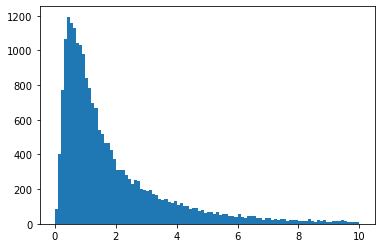

In [21]:
# Directly through Matplotlib
plt.hist(ak.flatten(events.kaons.p), bins=100, range=(0, 10))

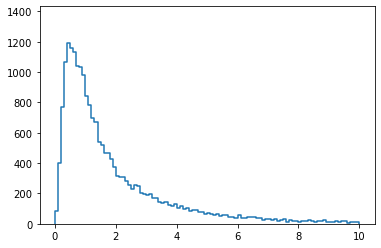

In [22]:
# Through mplhep and boost-histgram, which are more HEP-friendly

hep.histplot(bh.Histogram(bh.axis.Regular(100, 0, 10)).fill(
    
    ak.flatten(events.kaons.p)
    
))

If the particles are sorted (`ak.sort`/`ak.argsort` is [in development](https://github.com/scikit-hep/awkward-1.0/pull/168)), you might want to pick the first kaon from every event that has them (i.e. *use* the event structure).

This is an analysis choice: *you* have to decide you want this.

The `ak.num(events.kaons) > 0` selection is explicit as a reminder that empty events are not counted in the histogram.

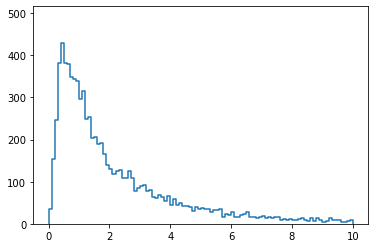

In [23]:
hep.histplot(bh.Histogram(bh.axis.Regular(100, 0, 10)).fill(
    
    events.kaons.p[ak.num(events.kaons) > 0, 0]
    
))

Or perhaps the maximum pion momentum in each event. This one must be flattened (with `axis=0`) to remove `None` values.

This flattening is explicit as a reminder that empty events are not counted in the histogram.

In [25]:
ak.max(events.kaons.p, axis=1)

<Array [4.98, None, 4.04, ... 1.15, 6.44, 4.18] type='10000 * ?float64'>

In [27]:
ak.flatten(ak.max(events.kaons.p, axis=1), axis=0)

<Array [4.98, 4.04, 2.2, ... 1.15, 6.44, 4.18] type='8496 * float64'>

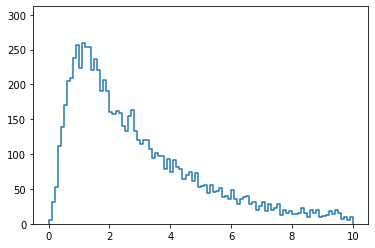

In [28]:
hep.histplot(bh.Histogram(bh.axis.Regular(100, 0, 10)).fill(
    
    ak.flatten(ak.max(events.kaons.p, axis=1), axis=0)
    
))

Or perhaps the momentum of the kaon with the farthest vertex. [ak.argmax](https://awkward-array.readthedocs.io/en/latest/_auto/ak.argmax.html) creates an array of integers selecting from each event.

In [45]:
?ak.argmax

Signature: ak.argmax(array, axis=None, keepdims=False, mask_identity=True)
Docstring:
Args:
    array: Data to find the index positions of the maximum values.
    axis (None or int): If None, combine all values from the array into
        a single scalar result; if an int, group by that axis: `0` is the
        outermost, `1` is the first level of nested lists, etc., and
        negative `axis` counts from the innermost: `-1` is the innermost,
        `-2` is the next level up, etc.
    keepdims (bool): If False, this reducer descreases the number of
        dimensions by 1; if True, the reduced values are wrapped in a new
        length-1 dimension so that the result of this operation may be
        broadcasted with the original array.
    mask_identity (bool): If True, reducing over empty lists results in
        None (an option type); otherwise, reducing over empty lists
        results in the operation's identity.

Returns the index position of the maximum value in each group of el

In [29]:
ak.argmax(abs(events.kaons.vtx), axis=1)

<Array [2, None, 0, 0, 1, ... 2, 0, 3, 1, 0] type='10000 * ?int64'>

In [23]:
?ak.singletons

Signature: ak.singletons(array, highlevel=True)
Docstring:
Args:
    array: Data to wrap in lists of length 1 if present and length 0
        if missing (None).
    highlevel (bool): If True, return an #ak.Array; otherwise, return
        a low-level #ak.layout.Content subclass.

Returns a singleton list (length 1) wrapping each non-missing value and
an empty list (length 0) in place of each missing value.

For example,

    >>> array = ak.Array([1.1, 2.2, None, 3.3, None, None, 4.4, 5.5])
    >>> print(ak.singletons(array))
    [[1.1], [2.2], [], [3.3], [], [], [4.4], [5.5]]
File:      ~/irishep/awkward-1.0/awkward1/operations/structure.py
Type:      function


In [30]:
# Get a length-1 list containing the index of the biggest vertex when there is one
# And a length-0 list when there isn't one
ak.singletons(ak.argmax(abs(events.kaons.vtx), axis=1))

<Array [[2], [], [0], [0, ... [3], [1], [0]] type='10000 * var * int64'>

In [31]:
# A nested integer array like this is what we need to select kaons with the biggest vertex
events.kaons[ak.singletons(ak.argmax(abs(events.kaons.vtx), axis=1))]

<Array [[{id: 130, pdg: 321, ... ] type='10000 * var * particle["id": uint64, "p...'>

In [32]:
events.kaons[ak.singletons(ak.argmax(abs(events.kaons.vtx), axis=1))].p

<Array [[2.56], [], [2.74, ... [6.17], [4.18]] type='10000 * var * float64'>

In [33]:
# Flatten the distinction between length-1 lists and length-0 lists
ak.flatten(events.kaons[ak.singletons(ak.argmax(abs(events.kaons.vtx), axis=1))].p)

<Array [2.56, 2.74, 2.2, ... 0.941, 6.17, 4.18] type='8496 * float64'>

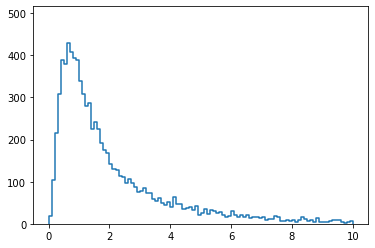

In [34]:
# Putting it all together...
hep.histplot(bh.Histogram(bh.axis.Regular(100, 0, 10)).fill(
    
    ak.flatten(events.kaons[ak.singletons(ak.argmax(abs(events.kaons.vtx), axis=1))].p)
    
))

If you're sending the data to a library that expects rectilinear structure, you might need to pad and clip the variable length lists.

[ak.pad_none](https://awkward-array.readthedocs.io/en/latest/_auto/ak.pad_none.html) puts `None` values at the end of each list to reach a minimum length.

In [51]:
?ak.pad_none

Signature: ak.pad_none(array, target, axis=1, clip=False, highlevel=True)
Docstring:
Args:
    array: Data containing nested lists to pad to a target length.
    target (int): The intended length of the lists. If `clip=True`,
        the output lists will have exactly this length; otherwise,
        they will have *at least* this length.
    axis (int): The dimension at which this operation is applied. The
        outermost dimension is `0`, followed by `1`, etc., and negative
        values count backward from the innermost: `-1` is the innermost
        dimension, `-2` is the next level up, etc.
    clip (bool): If True, the output lists will have regular lengths
        (#ak.types.RegularType) of exactly `target`; otherwise the
        output lists will have in-principle variable lengths
        (#ak.types.ListType) of at least `target`.
    highlevel (bool): If True, return an #ak.Array; otherwise, return
        a low-level #ak.layout.Content subclass.

Increase the lengths of lis

In [35]:
# pad them                     look at the first 30
ak.pad_none(events.kaons.id, 3)[:30].tolist()

[[81, 109, 130, 136, 137, 145],
 [None, None, None],
 [96, 98, None],
 [78, None, None],
 [62, 101, None],
 [None, None, None],
 [61, 63, 90],
 [None, None, None],
 [67, 70, 104, 105, 106, 107],
 [61, 62, 73, 99],
 [64, 65, None],
 [65, None, None],
 [93, 140, 153, 188],
 [52, 85, None],
 [35, 44, 70],
 [70, 74, None],
 [75, 76, None],
 [87, 88, 132, 153, 191, 193],
 [58, 70, 79, 88],
 [None, None, None],
 [None, None, None],
 [58, 98, 99],
 [109, 110, None],
 [51, 72, None],
 [83, None, None],
 [None, None, None],
 [45, None, None],
 [67, 98, 181],
 [None, None, None],
 [54, 57, None]]

The lengths are still irregular, so you can also `clip=True` them.

In [36]:
# pad them                                look at the first 30
ak.pad_none(events.kaons.id, 3, clip=True)[:30].tolist()

[[81, 109, 130],
 [None, None, None],
 [96, 98, None],
 [78, None, None],
 [62, 101, None],
 [None, None, None],
 [61, 63, 90],
 [None, None, None],
 [67, 70, 104],
 [61, 62, 73],
 [64, 65, None],
 [65, None, None],
 [93, 140, 153],
 [52, 85, None],
 [35, 44, 70],
 [70, 74, None],
 [75, 76, None],
 [87, 88, 132],
 [58, 70, 79],
 [None, None, None],
 [None, None, None],
 [58, 98, 99],
 [109, 110, None],
 [51, 72, None],
 [83, None, None],
 [None, None, None],
 [45, None, None],
 [67, 98, 181],
 [None, None, None],
 [54, 57, None]]

The library we're sending this to might not be able to deal with missing values, so choose a replacement to fill them with.

In [59]:
?ak.fill_none

Signature: ak.fill_none(array, value, highlevel=True)
Docstring:
Args:
    array: Data in which to replace None with a given value.
    value: Data with which to replace None.
    highlevel (bool): If True, return an #ak.Array; otherwise, return
        a low-level #ak.layout.Content subclass.

Replaces missing values (None) with a given `value`.

For example, in the following `array`,

    ak.Array([[1.1, None, 2.2], [], [None, 3.3, 4.4]])

The None values could be replaced with `0` by

    >>> ak.fill_none(array, 0)
    <Array [[1.1, 0, 2.2], [], [0, 3.3, 4.4]] type='3 * var * float64'>

The replacement value doesn't strictly need the same type as the
surrounding data. For example, the None values could also be replaced
by a string.

    >>> ak.fill_none(array, "hi")
    <Array [[1.1, 'hi', 2.2], ... ['hi', 3.3, 4.4]] type='3 * var * union[float64, s...'>

The list content now has a union type:

    >>> ak.type(ak.fill_none(array, "hi"))
    3 * var * union[float64, string]

The valu

In [37]:
# fill with -1 <- pad them                                  look at the first 30
ak.fill_none(ak.pad_none(events.kaons.id, 3, clip=True), -1)[:30].tolist()

[[81, 109, 130],
 [-1, -1, -1],
 [96, 98, -1],
 [78, -1, -1],
 [62, 101, -1],
 [-1, -1, -1],
 [61, 63, 90],
 [-1, -1, -1],
 [67, 70, 104],
 [61, 62, 73],
 [64, 65, -1],
 [65, -1, -1],
 [93, 140, 153],
 [52, 85, -1],
 [35, 44, 70],
 [70, 74, -1],
 [75, 76, -1],
 [87, 88, 132],
 [58, 70, 79],
 [-1, -1, -1],
 [-1, -1, -1],
 [58, 98, 99],
 [109, 110, -1],
 [51, 72, -1],
 [83, -1, -1],
 [-1, -1, -1],
 [45, -1, -1],
 [67, 98, 181],
 [-1, -1, -1],
 [54, 57, -1]]

These are still Awkward-brand arrays; the downstream library might complain if they're not NumPy-brand, so use [ak.to_numpy](https://awkward-array.readthedocs.io/en/latest/_auto/ak.to_numpy.html) or simply cast it with NumPy's `np.asarray`.

In [67]:
?ak.to_numpy

Signature: ak.to_numpy(array)
Docstring:
Converts `array` (many types supported, including all Awkward Arrays and
Records) into a NumPy array, if possible.

If the data are numerical and regular (nested lists have equal lengths
in each dimension, as described by the #type), they can be losslessly
converted to a NumPy array and this function returns without an error.

Otherwise, the function raises an error. It does not create a NumPy
array with dtype `"O"` for `np.object_` (see the
[note on object_ type](https://docs.scipy.org/doc/numpy/reference/arrays.scalars.html#arrays-scalars-built-in))
since silent conversions to dtype `"O"` arrays would not only be a
significant performance hit, but would also break functionality, since
nested lists in a NumPy `"O"` array are severed from the array and
cannot be sliced as dimensions.

If `array` is a scalar, it is converted into a NumPy scalar.

See also #ak.from_numpy.
File:      ~/irishep/awkward-1.0/awkward1/operations/convert.py
Type:      f

In [42]:
np.asarray(ak.fill_none(ak.pad_none(events.kaons.id, 3, clip=True), -1))

array([[ 81, 109, 130],
       [ -1,  -1,  -1],
       [ 96,  98,  -1],
       ...,
       [ 61,  66, 106],
       [ 75,  81,  -1],
       [ 40,  -1,  -1]])

If you try to convert an Awkward Array as NumPy and structure would be lost, you get an error. (You won't accidentally eliminate structure.)

In [43]:
try:
    np.asarray(events.kaons.id)
except Exception as err:
    print(type(err), str(err))

<class 'ValueError'> in ListOffsetArray64, cannot convert to RegularArray because subarray lengths are not regular


## Broadcasting flat arrays and jagged arrays

NumPy lets you combine arrays and scalars in a mathematical expression by first "broadcasting" the scalar to an array of the same length.

In [47]:
print(np.array([1, 2, 3, 4, 5]) + 100)

[101 102 103 104 105]


Awkward Array does the same thing, except that each element of a flat array can be broadcasted to each nested list of a jagged array.

<img src="../docs-images/diagrams/cartoon-broadcasting.png" width="300">

In [46]:
print(ak.Array([[1, 2, 3], [], [4, 5], [6]]) + np.array([100, 200, 300, 400]))

[[101, 102, 103], [], [304, 305], [406]]


This is useful for emulating

```python
all_vertices = []
for event in events:
    vertices = []
    for kaon in events.kaons:
        all_vertices.append((kaon.vtx.x - event.true.x,
                             kaon.vtx.y - event.true.y))
    all_vertices.append(vertices)
```

where `event.true.x` and `y` have only one value per event but `kaon.vtx.x` and `y` have one per kaon.

In [54]:
#       one value per kaon   one per event
ak.zip([events.kaons.vtx.x - events.true.x,
        events.kaons.vtx.y - events.true.y])

<Array [[(0.0087, 0.00529), ... 0.00476)]] type='10000 * var * (float64, float64)'>

You don't have to do anything special for this: broadcasting is a common feature of all functions that apply to more than one array.

You can get it explicitly with [ak.broadcast_arrays](https://awkward-array.readthedocs.io/en/latest/_auto/ak.broadcast_arrays.html).

In [55]:
?ak.broadcast_arrays

Signature: ak.broadcast_arrays(*arrays, **kwargs)
Docstring:
Args:
    arrays: Arrays to broadcast into the same structure.
    highlevel (bool, default is True): If True, return an #ak.Array;
        otherwise, return a low-level #ak.layout.Content subclass.

Like NumPy's
[broadcast_arrays](https://docs.scipy.org/doc/numpy/reference/generated/numpy.broadcast_arrays.html)
function, this function returns the input `arrays` with enough elements
duplicated that they can be combined element-by-element.

For NumPy arrays, this means that scalars are replaced with arrays with
the same scalar value repeated at every element of the array, and regular
dimensions are created to increase low-dimensional data into
high-dimensional data.

For example,

    >>> ak.broadcast_arrays(5,
    ...                     [1, 2, 3, 4, 5])
    [<Array [5, 5, 5, 5, 5] type='5 * int64'>,
     <Array [1, 2, 3, 4, 5] type='5 * int64'>]

and

    >>> ak.broadcast_arrays(np.array([1, 2, 3]),
    ...                  

In [58]:
ak.broadcast_arrays(events.true.x, events.kaons.vtx.x)

[<Array [[0, 0, 0, 0, 0, 0], ... [0, 0], [0]] type='10000 * var * float64'>,
 <Array [[0.0087, -0.00317, ... [-0.00209]] type='10000 * var * float64'>]

## Combinatorics: cartesian and combinations

At all levels of a physics analysis, we need to compare objects drawn from different collections.

   * **Gen-reco matching:** to associate a reconstructed particle with its generator-level parameters.
   * **Cleaning:** assocating soft photons with a reconstructed electron or leptons to a jet.
   * **Bump-hunting:** looking for mass peaks in pairs of particles.
   * **Dalitz analysis:** looking for resonance structure in triples of particles.

To do this with array-at-a-time operations, use one function to generate all the combinations, 

<img src="https://github.com/diana-hep/femtocode/raw/master/docs/explode.png" width="300">

apply "flat" operations,

<img src="https://github.com/diana-hep/femtocode/raw/master/docs/flat.png" width="300">

then use "reducers" to get one value per particle or per event again.

<img src="https://github.com/diana-hep/femtocode/raw/master/docs/reduce.png" width="300">

### Cartesian and combinations

The two main "explode" operations are [ak.cartesian](https://awkward-array.readthedocs.io/en/latest/_auto/ak.cartesian.html) and [ak.combinations](https://awkward-array.readthedocs.io/en/latest/_auto/ak.combinations.html).

The first generates the **Cartesian product** (a.k.a. cross product) of two collections **per nested list**.

<img src="../docs-images/diagrams/cartoon-cartesian.png" width="300">

The second generates **distinct combinations** (i.e. "n choose k") of a collection with itself **per nested list**.

<img src="../docs-images/diagrams/cartoon-combinations.png" width="300">

In [59]:
?ak.cartesian

Signature:
ak.cartesian(
    arrays,
    axis=1,
    nested=None,
    parameters=None,
    with_name=None,
    highlevel=True,
)
Docstring:
Args:
    arrays (dict or iterable of arrays): Arrays on which to compute the
        Cartesian product.
    axis (int): The dimension at which this operation is applied. The
        outermost dimension is `0`, followed by `1`, etc., and negative
        values count backward from the innermost: `-1` is the innermost
        dimension, `-2` is the next level up, etc.
    nested (None, True, False, or iterable of str or int): If None or
        False, all combinations of elements from the `arrays` are
        produced at the same level of nesting; if True, they are grouped
        in nested lists by combinations that share a common item from
        each of the `arrays`; if an iterable of str or int, group common
        items for a chosen set of keys from the `array` dict or slots
        of the `array` iterable.
    parameters (dict): Parameters f

In [60]:
?ak.combinations

Signature:
ak.combinations(
    array,
    n,
    replacement=False,
    axis=1,
    keys=None,
    parameters=None,
    with_name=None,
    highlevel=True,
)
Docstring:
Args:
    array: Array from which to choose `n` items without replacement.
    n (int): The number of items to choose in each list: `2` chooses
        unique pairs, `3` chooses unique triples, etc.
    replacement (bool): If True, combinations that include the same
        item more than once are allowed; otherwise each item in a
        combinations is strictly unique.
    axis (int): The dimension at which this operation is applied. The
        outermost dimension is `0`, followed by `1`, etc., and negative
        values count backward from the innermost: `-1` is the innermost
        dimension, `-2` is the next level up, etc.
    keys (None or list of str): If None, the pairs/triples/etc. are
        tuples with unnamed fields; otherwise, these `keys` name the
        fields. The number of `keys` must be equal to 

In [64]:
ak.to_list(ak.cartesian(([[1, 2, 3], [], [4]],
                         [["a", "b"], ["c"], ["d", "e"]])))

[[(1, 'a'), (1, 'b'), (2, 'a'), (2, 'b'), (3, 'a'), (3, 'b')],
 [],
 [(4, 'd'), (4, 'e')]]

In [67]:
ak.to_list(ak.combinations([["a", "b", "c", "d"], [], [1, 2]], 2))

[[('a', 'b'), ('a', 'c'), ('a', 'd'), ('b', 'c'), ('b', 'd'), ('c', 'd')],
 [],
 [(1, 2)]]

To search for $\Lambda^0 \to \pi p$, we need to compute the mass of pairs drawn from these two collections.

In [69]:
pairs = ak.cartesian([events.pions, events.protons])
pairs

<Array [[({id: 79, pdg: 211, ... [], []] type='10000 * var * (particle["id": uin...'>

In [76]:
?ak.unzip

Signature: ak.unzip(array)
Docstring:
If the `array` contains tuples or records, this operation splits them
into a Python tuple of arrays, one for each field.

If the `array` does not contain tuples or records, the single `array`
is placed in a length 1 Python tuple.

For example,

    >>> array = ak.Array([{"x": 1.1, "y": [1]},
    ...                   {"x": 2.2, "y": [2, 2]},
    ...                   {"x": 3.3, "y": [3, 3, 3]}])
    >>> x, y = ak.unzip(array)
    >>> x
    <Array [1.1, 2.2, 3.3] type='3 * float64'>
    >>> y
    <Array [[1], [2, 2], [3, 3, 3]] type='3 * var * int64'>
File:      ~/irishep/awkward-1.0/awkward1/operations/structure.py
Type:      function


In [24]:
def mass(pairs, left_mass, right_mass):
    left, right = ak.unzip(pairs)
    left_energy = np.sqrt(left.p**2 + left_mass**2)
    right_energy = np.sqrt(right.p**2 + right_mass**2)
    return np.sqrt((left_energy + right_energy)**2 -
                   (left.px + right.px)**2 -
                   (left.py + right.py)**2 -
                   (left.pz + right.pz)**2)

In [74]:
mass(pairs, 0.139570, 0.938272)

<Array [[1.36, 1.64, 1.16, 1.16, ... [], []] type='10000 * var * float64'>

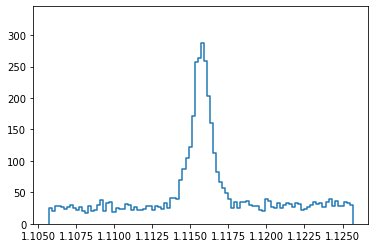

In [75]:
hep.histplot(bh.Histogram(bh.axis.Regular(100, 1.115683 - 0.01, 1.115683 + 0.01)).fill(
    ak.flatten(mass(pairs, 0.139570, 0.938272))
))

We can improve the peak by selecting for opposite charges and large vertexes.

In [90]:
def opposite(pairs):
    left, right = ak.unzip(pairs)
    return pairs[left.charge != right.charge]

def distant(pairs):
    left, right = ak.unzip(pairs)
    return pairs[np.logical_and(abs(left.vtx) > 0.10, abs(right.vtx) > 0.10)]

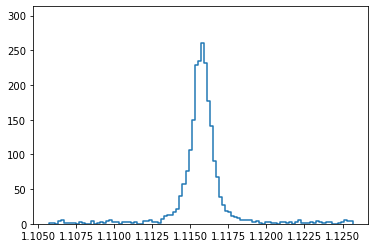

In [91]:
hep.histplot(bh.Histogram(bh.axis.Regular(100, 1.115683 - 0.01, 1.115683 + 0.01)).fill(
    ak.flatten(mass(distant(opposite(pairs)), 0.139570, 0.938272))
))

Alternatively, all of these functions could have been methods on the pair objects for reuse.

(This is to make the point that any kind of object can have methods, not just particles.)

In [13]:
class ParticlePairArray(ak.Array):
    __name__ = "Pairs"
    
    def mass(self, left_mass, right_mass):
        left, right = self.slot0, self.slot1
        left_energy = np.sqrt(left.p**2 + left_mass**2)
        right_energy = np.sqrt(right.p**2 + right_mass**2)
        return np.sqrt((left_energy + right_energy)**2 -
                       (left.px + right.px)**2 -
                       (left.py + right.py)**2 -
                       (left.pz + right.pz)**2)
    
    def opposite(self):
        return self[self.slot0.charge != self.slot1.charge]
    
    def distant(self, cut):
        return self[np.logical_and(abs(self.slot0.vtx) > cut, abs(self.slot1.vtx) > cut)]

ak.behavior["*", "pair"] = ParticlePairArray

In [14]:
pairs = ak.cartesian([events.pions, events.protons], with_name="pair")
pairs

<Pairs [[({id: 79, pdg: 211, ... [], []] type='10000 * var * pair[particle["id":...'>

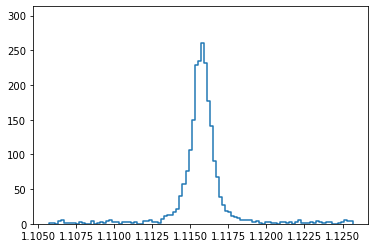

In [15]:
hep.histplot(bh.Histogram(bh.axis.Regular(100, 1.115683 - 0.01, 1.115683 + 0.01)).fill(
    ak.flatten(pairs.opposite().distant(0.10).mass(0.139570, 0.938272))
))

**Self-study question:** why does the call to `mass` have to be last?

An example for `ak.combinations`: $K_S \to \pi\pi$.

In [16]:
pairs = ak.combinations(events.pions, 2, with_name="pair")
pairs

<Pairs [[({id: 79, pdg: 211, ... )]] type='10000 * var * pair[particle["id": uin...'>

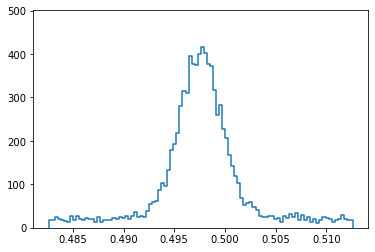

In [17]:
hep.histplot(bh.Histogram(bh.axis.Regular(100, 0.497611 - 0.015, 0.497611 + 0.015)).fill(
    ak.flatten(pairs.opposite().distant(0.10).mass(0.139570, 0.139570))
))

**Bonus problem:** $D^0 \to K^- \pi^+ \pi^0$

In [33]:
pizero_candidates = ak.combinations(events.prt[events.prt.pdg == Particle.from_string("gamma").pdgid], 2, with_name="pair")
pizero = pizero_candidates[pizero_candidates.mass(0, 0) - 0.13498 < 0.000001]
pizero["px"] = pizero.slot0.px + pizero.slot1.px
pizero["py"] = pizero.slot0.py + pizero.slot1.py
pizero["pz"] = pizero.slot0.pz + pizero.slot1.pz
pizero["p"] = np.sqrt(pizero.px**2 + pizero.py**2 + pizero.pz**2)
pizero

<Pairs [[{0: {id: 104, ... p: 3.14}]] type='10000 * var * pair["0": particle["id...'>

In [58]:
kminus = events.prt[events.prt.pdg == Particle.from_string("K-").pdgid]
piplus = events.prt[events.prt.pdg == Particle.from_string("pi+").pdgid]

triples = ak.cartesian({"kminus": kminus[abs(kminus.vtx) > 0.03],
                        "piplus": piplus[abs(piplus.vtx) > 0.03],
                        "pizero": pizero[np.logical_and(abs(pizero.slot0.vtx) > 0.03, abs(pizero.slot1.vtx) > 0.03)]})
triples

<Array [[], [], ... p: 1.19}}], []] type='10000 * var * {"kminus": particle["id"...'>

In [59]:
ak.num(triples)

<Array [0, 0, 2, 15, 0, 0, ... 5, 0, 3, 9, 0] type='10000 * int64'>

In [60]:
def mass2(left, left_mass, right, right_mass):
    left_energy = np.sqrt(left.p**2 + left_mass**2)
    right_energy = np.sqrt(right.p**2 + right_mass**2)
    return ((left_energy + right_energy)**2 -
            (left.px + right.px)**2 -
            (left.py + right.py)**2 -
            (left.pz + right.pz)**2)

In [61]:
mKpi = mass2(triples.kminus, 0.493677, triples.piplus, 0.139570)

In [63]:
mpipi = mass2(triples.piplus, 0.139570, triples.pizero, 0.1349766)

This Dalitz plot doesn't look right (doesn't cut off at kinematic limits), but I'm going to leave it as an exercise for the reader.

In [ ]:
dalitz = bh.Histogram(bh.axis.Regular(50, 0, 3), bh.axis.Regular(50, 0, 2))
dalitz.fill(ak.flatten(mKpi), ak.flatten(mpipi))

X, Y = dalitz.axes.edges

fig, ax = plt.subplots()
mesh = ax.pcolormesh(X.T, Y.T, dalitz.view().T)
fig.colorbar(mesh)

## Reducing from combinations

The mass-peak examples above don't need to "reduce" combinations, but many applications do.

<img src="https://github.com/diana-hep/femtocode/raw/master/docs/reduce.png" width="300">

Suppose that we want to find the "nearest photon to each electron" (e.g. bremsstrahlung).

In [12]:
electrons = events.prt[abs(events.prt.pdg) == abs(Particle.from_string("e-").pdgid)]
photons   = events.prt[events.prt.pdg == Particle.from_string("gamma").pdgid]

The problem with the raw output of `ak.cartesian` is that all the combinations are mixed together in the same lists.

In [13]:
ak.to_list(ak.cartesian([electrons[["pdg", "id"]], photons[["pdg", "id"]]])[8])

[({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 86}),
 ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 87}),
 ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 99}),
 ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 100}),
 ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 112}),
 ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 113}),
 ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 116}),
 ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 117}),
 ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 118}),
 ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 119}),
 ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 120}),
 ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 121}),
 ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 124}),
 ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 125}),
 ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 133}),
 ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 136}),
 ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 137}),
 ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 138}),
 ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 139}),
 ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 143}),
 ({

We can fix this by asking for `nested=True`, which adds another level of nesting to the output.

In [14]:
ak.to_list(ak.cartesian([electrons[["pdg", "id"]], photons[["pdg", "id"]]], nested=True)[8])

[[({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 86}),
  ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 87}),
  ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 99}),
  ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 100}),
  ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 112}),
  ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 113}),
  ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 116}),
  ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 117}),
  ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 118}),
  ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 119}),
  ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 120}),
  ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 121}),
  ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 124}),
  ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 125}),
  ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 133}),
  ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 136}),
  ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 137}),
  ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 138}),
  ({'pdg': 11, 'id': 13}, {'pdg': 22, 'id': 139}),
  ({'pdg': 11, 'id': 13}, {'pdg': 

All electron-photon pairs associated with a given electron are grouped in a list-within-each-list.

Now we can apply reducers to this inner dimension to sum over some quantity, pick the best one, etc.

In [15]:
def cos_angle(pairs):
    left, right = ak.unzip(pairs)
    return left.dir.x*right.dir.x + left.dir.y*right.dir.y + left.dir.z*right.dir.z

In [16]:
electron_photons = ak.cartesian([electrons, photons], nested=True)

In [17]:
cos_angle(electron_photons)

<Array [[[0.155, -0.413, ... -0.957, -0.999]]] type='10000 * var * var * float64'>

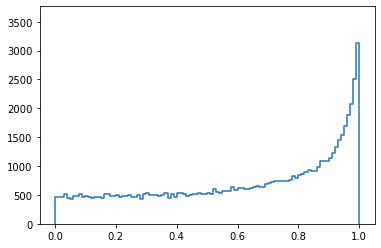

In [18]:
hep.histplot(bh.Histogram(bh.axis.Regular(100, 0, 1)).fill(
    ak.flatten(cos_angle(electron_photons), axis=None)    # a good reason to use flatten axis=None
))

We pick the "maximum according to a function" using the same `ak.singletons(ak.argmax(f(x))` trick as above.

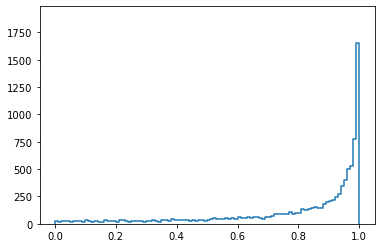

In [19]:
best_electron_photons = electron_photons[ak.singletons(ak.argmax(cos_angle(electron_photons), axis=2))]

hep.histplot(bh.Histogram(bh.axis.Regular(100, 0, 1)).fill(
    ak.flatten(cos_angle(best_electron_photons), axis=None)
))

By construction, `best_electron_photons` has zero or one elements in each *inner* nested list.

In [20]:
ak.num(electron_photons, axis=2), ak.num(best_electron_photons, axis=2)

(<Array [[16], [14], [9], ... 18], [10], [4]] type='10000 * var * int64'>,
 <Array [[1], [1], [1], ... [1, 1], [1], [1]] type='10000 * var * int64'>)

Since we no longer care about that *inner* structure, we could flatten it at `axis=2` (leaving `axis=1` untouched).

In [21]:
best_electron_photons

<Array [[[({id: 12, pdg: 11, ... )]]] type='10000 * var * var * (particle["id": ...'>

In [22]:
ak.flatten(best_electron_photons, axis=2)

<Array [[({id: 12, pdg: 11, ... )]] type='10000 * var * (particle["id": uint64, ...'>

But it would be better to invert the `ak.singletons` by calling `ak.firsts`.

In [24]:
?ak.singletons

Signature: ak.singletons(array, highlevel=True)
Docstring:
Args:
    array: Data to wrap in lists of length 1 if present and length 0
        if missing (None).
    highlevel (bool): If True, return an #ak.Array; otherwise, return
        a low-level #ak.layout.Content subclass.

Returns a singleton list (length 1) wrapping each non-missing value and
an empty list (length 0) in place of each missing value.

For example,

    >>> array = ak.Array([1.1, 2.2, None, 3.3, None, None, 4.4, 5.5])
    >>> print(ak.singletons(array))
    [[1.1], [2.2], [], [3.3], [], [], [4.4], [5.5]]

See #ak.firsts to invert this function.
File:      ~/irishep/awkward-1.0/awkward1/operations/structure.py
Type:      function


In [25]:
?ak.firsts

Signature: ak.firsts(array, axis=1, highlevel=True)
Docstring:
Args:
    array: Data from which to select the first elements from nested lists.
    axis (int): The dimension at which this operation is applied. The
        outermost dimension is `0`, followed by `1`, etc., and negative
        values count backward from the innermost: `-1` is the innermost
        dimension, `-2` is the next level up, etc.
    highlevel (bool): If True, return an #ak.Array; otherwise, return
        a low-level #ak.layout.Content subclass.

Selects the first element of each non-empty list and inserts None for each
empty list.

For example,

    >>> array = ak.Array([[1.1], [2.2], [], [3.3], [], [], [4.4], [5.5]])
    >>> print(ak.firsts(array))
    [1.1, 2.2, None, 3.3, None, None, 4.4, 5.5]

See #ak.singletons to invert this function.
File:      ~/irishep/awkward-1.0/awkward1/operations/structure.py
Type:      function


In [23]:
ak.firsts(best_electron_photons, axis=2)

<Array [[({id: 12, pdg: 11, ... )]] type='10000 * var * ?(particle["id": uint64,...'>

Because then we can get back one value for each electron (with `None` if `ak.argmax` resulted in `None` because there were no pairs).

In [26]:
ak.num(electrons), ak.num(ak.firsts(best_electron_photons, axis=2))

(<Array [1, 1, 1, 1, 1, 1, ... 2, 1, 1, 2, 1, 1] type='10000 * int64'>,
 <Array [1, 1, 1, 1, 1, 1, ... 2, 1, 1, 2, 1, 1] type='10000 * int64'>)

In [27]:
ak.all(ak.num(electrons) == ak.num(ak.firsts(best_electron_photons, axis=2)))

True

And that means that we can make this "closest photon" an attribute of the electrons. We have now performed electron-photon matching.

In [29]:
electrons["photon"] = ak.firsts(best_electron_photons, axis=2)
ak.to_list(electrons[8])

[{'id': 13,
  'pdg': 11,
  'trk_id': 0.0,
  'charge': -1.0,
  'dir': {'x': -0.09588639882904162,
   'y': 0.09112746606282955,
   'z': 0.9912121788237702},
  'p': 9.375209905971012,
  'px': 0.8557761175294573,
  'py': -0.8985850776773974,
  'pz': 9.292725804405222,
  'm': 0.0,
  'time': 0.0,
  'is_beam': False,
  'is_stable': False,
  'gen_code': False,
  'mother': {'id': 0, 'second_id': 0},
  'pol': {'has_info': 0.0, 'x': 0.0, 'y': 0.0, 'z': 0.0},
  'vtx': {'has_info': True,
   'id': 0,
   'x': 0.018693160610243204,
   'y': -0.00831403948815941,
   'z': 0.00955870729245701,
   't': 0.0},
  'smear': {'has_info': True,
   'has_e': True,
   'has_p': True,
   'has_pid': False,
   'has_vtx': True,
   'has_any_eppid': True,
   'orig': {'tot_e': 9.160443640616137,
    'p': 9.160443626363536,
    'px': -0.8783619510084464,
    'py': 0.8347680156819064,
    'pz': 9.07994328588012,
    'vtx': {'x': 0.0, 'y': 0.0, 'z': 0.0}}},
  'photon': ({'id': 13,
    'pdg': 11,
    'trk_id': 0.0,
    'charge'

## Imperative, but still fast, programming in Numba

## Grafting jagged data onto Pandas

## NumExpr, Autograd, and other third-party libraries